# Fisheries competition

In this notebook we're going to investigate a range of different techniques for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring). In this competition, The Nature Conservancy asks you to help them detect which species of fish appears on a fishing boat, based on images captured from boat cameras of various angles. Your goal is to predict the likelihood of fish species in each picture. Eight target categories are available in this dataset: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other 

You can use [this](https://github.com/floydwch/kaggle-cli) api to download the data from Kaggle.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.plots import *
from fastai.io import get_data

PATH = "data/fish/"

## First look at fish pictures

In [10]:
!ls {PATH}

all.json   models			   test		  train.bak
annos	   sample			   test_stg1.zip  train.zip
annos.bak  sample_submission_stg1.csv	   tmp		  trn_bb_labels
__MACOSX   sample_submission_stg1.csv.zip  train


In [12]:
!ls {PATH}train

ALB  BET  DOL  LAG  NoF  OTHER	SHARK  YFT


In [13]:
files = !ls {PATH}train/ALB | head
files

['img_00003.jpg',
 'img_00010.jpg',
 'img_00012.jpg',
 'img_00015.jpg',
 'img_00019.jpg',
 'img_00020.jpg',
 'img_00029.jpg',
 'img_00032.jpg',
 'img_00037.jpg',
 'img_00038.jpg']

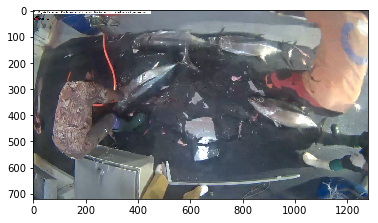

In [15]:
img = plt.imread(f'{PATH}train/ALB/{files[0]}')
plt.imshow(img);

## Data pre-processing

Here we are changing the structure of the training data to make it more convinient. We will have all images in a common directory `images` and will have a file `train.csv` with all labels. 

In [16]:
from os import listdir
from os.path import join
train_path = f'{PATH}/train'

In [17]:
dirs = [d for d in listdir(train_path) if os.path.isdir(join(train_path,d))]
print(dirs)

['DOL', 'NoF', 'LAG', 'SHARK', 'OTHER', 'BET', 'YFT', 'ALB']


In [20]:
train_dict = {d: listdir(join(train_path, d)) for d in dirs}

In [21]:
train_dict["LAG"][:10]

['img_07087.jpg',
 'img_03771.jpg',
 'img_04297.jpg',
 'img_07830.jpg',
 'img_00091.jpg',
 'img_06536.jpg',
 'img_05005.jpg',
 'img_07334.jpg',
 'img_04958.jpg',
 'img_02349.jpg']

In [22]:
sum(len(v) for v in train_dict.values())

3777

In [23]:
with open(f"{PATH}train.csv", "w") as csv:
    csv.write("img,label\n")
    for d in dirs:
        for f in train_dict[d]: csv.write(f'{f},{d}\n')

In [24]:
img_path = f'{PATH}images'
os.makedirs(img_path, exist_ok=True)

In [25]:
!cp {PATH}train/*/*.jpg {PATH}images/

## Our first model

Here we import the libraries we need. We'll learn about what each does during the course.

In [26]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [29]:
sz=299
bs=64
csv_fname = os.path.join(PATH, "train.csv")
n = len(list(open(csv_fname)))-1
val_idxs = get_cv_idxs(n)

In [30]:
tfms = tfms_from_model(resnet34, sz)
data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs)

In [43]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam, ps=0.5)

In [38]:
lrf=learn.lr_find()
learn.sched.plot()

A Jupyter Widget

 44%|████▍     | 21/48 [00:00<00:10,  2.63it/s, loss=2.41]


In [44]:
learn.fit(0.01, 2)

A Jupyter Widget

[ 0.      0.6329  0.5899  0.819 ]                         
[ 1.      0.6011  0.3648  0.903 ]                          



In [45]:
lrs=np.array([1e-4,1e-3,1e-2])
learn.precompute=False

In [46]:
learn.freeze_to(6)

In [47]:
learn.fit(lrs/10, 2, cycle_len=1)

A Jupyter Widget

[ 0.      0.2599  0.2416  0.9228]                          
[ 1.      0.1859  0.1718  0.9482]                          



## Predicting bounding boxes

### Getting bounding boxes data

This part needs to run just the first time to get the file `trn_bb_labels`

In [48]:
import json
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [49]:
def get_annotations():
    annot_urls = [
        '5458/bet_labels.json', '5459/shark_labels.json', '5460/dol_labels.json',
        '5461/yft_labels.json', '5462/alb_labels.json', '5463/lag_labels.json'
    ]
    cache_subdir = os.path.abspath(os.path.join(PATH, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    os.makedirs(cache_subdir, exist_ok=True)
    
    for url_suffix in annot_urls:
        fname = url_suffix.rsplit('/', 1)[-1]
        get_data(url_prefix + url_suffix, f'{cache_subdir}/{fname}')

In [50]:
# run this code to get annotation files
get_annotations()

In [51]:
# creates a dictionary of all annotations per file
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open(f'{PATH}annos/{c}_labels.json', 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [52]:
raw_filenames = pd.read_csv(csv_fname)["img"].values

In [53]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb):
    bb = [bb[p] for p in bb_params]
    bb[2] = max(bb[2], 0)
    bb[3] = max(bb[3], 0)
    return bb

In [54]:
trn_bbox = np.stack([convert_bb(bb_json[f]) for f in raw_filenames]).astype(np.float32)
trn_bb_labels = [f + ',' + ' '.join(map(str,o))+'\n' for f,o in zip(raw_filenames,trn_bbox)]

In [55]:
open(f'{PATH}trn_bb_labels', 'w').writelines(trn_bb_labels)

In [56]:
fnames,csv_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_labels', skip_header=False)

In [57]:
def bb_corners(bb):
    bb = np.array(bb, dtype=np.float32)
    row1 = bb[3]
    col1 = bb[2]
    row2 = row1 + bb[0]
    col2 = col1 + bb[1]
    return [row1, col1, row2, col2]

In [58]:
f = 'img_02642.jpg'
bb = csv_labels[f]
print(bb)
bb_corners(bb)

['195.927', '320.607', '954.697', '699.399']


[699.39899, 954.69702, 895.32599, 1275.304]

In [59]:
new_labels = [f + "," + " ".join(map(str, bb_corners(csv_labels[f]))) + "\n" for f in raw_filenames]

In [60]:
open(f'{PATH}trn_bb_corners_labels', 'w').writelines(new_labels)

### Looking at bounding boxes

In [61]:
# reading bb file
bbox = {}
bb_data = pd.read_csv(f'{PATH}trn_bb_labels', header=None)

In [62]:
fnames,csv_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_labels', skip_header=False)
fnames,corner_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_corners_labels', skip_header=False)

In [63]:
corner_labels["img_06297.jpg"]

['396.21', '404.67', '504.78', '623.22']

In [64]:
csv_labels["img_06297.jpg"]

['108.57', '218.55', '404.67', '396.21']

In [65]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(path, f='img_04908.jpg'):
    file_path = f'{path}images/{f}'
    bb = csv_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_rect(bb))

In [66]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def show_corner_bb(path, f='img_04908.jpg'):
    file_path = f'{path}images/{f}'
    bb = corner_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_corner_rect(bb))

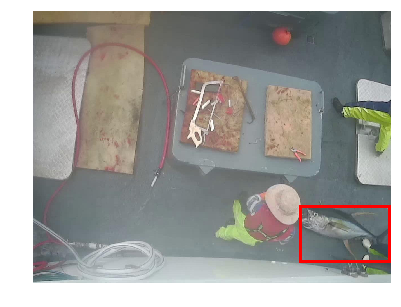

In [67]:
show_corner_bb(PATH, f = 'img_02642.jpg')

### Model predicting bounding boxes

In [96]:
label_csv=f'{PATH}trn_bb_labels'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [108]:
data = ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms, val_idxs=val_idxs,
                                    continuous=True, skip_header=False)

## Looking into size of images

In [97]:
f="img_06297.jpg"
PIL.Image.open(PATH+"images/" + f).size

(1280, 720)

In [ ]:
sizes = [PIL.Image.open(PATH+f).size for f in data.trn_ds.fnames]
raw_val_sizes = [PIL.Image.open(PATH+f).size for f in data.val_ds.fnames]